In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import cirq

q = cirq.LineQubit.range(2)
c = cirq.Circuit(cirq.X(q[0]))

In [91]:
noise = cirq.DepolarizingChannel(p=0.01)
sim = cirq.DensityMatrixSimulator(
    noise=noise,
)

In [106]:
import supermarq

experiment = supermarq.qcvv.CB(c, num_channels=10)
experiment.prepare_experiment(num_circuits=20, cycle_depths=[1, 5, 10])
experiment.run_with_simulator(simulator=sim, repetitions=1_000)
experiment.collect_data()

Building circuits:   0%|          | 0/600 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/600 [00:00<?, ?it/s]

True

<Axes: xlabel='cycle_depth', ylabel='expectation'>

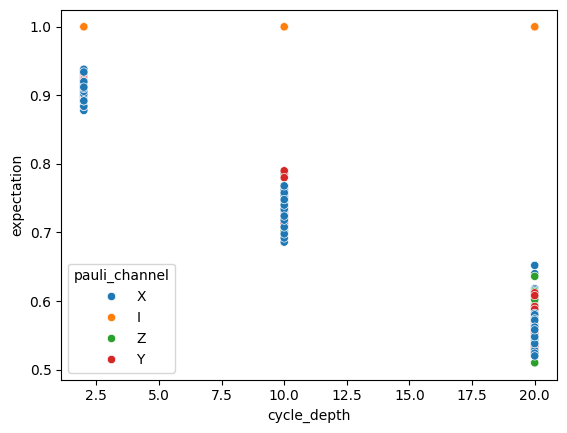

In [107]:
import pandas as pd
import seaborn as sns
sns.scatterplot(experiment.raw_data, x="cycle_depth", y="expectation", hue="pauli_channel")

In [108]:
experiment.analyze_results()


,channel,decay,decay_std,const,const_std
0,X,0.973915,0.000309,0.958296,0.003941
1,I,1.000000,0.000000,1.000000,0.000000
2,Z,0.974571,0.000624,0.956528,0.007944
3,Y,0.973229,0.000346,0.961508,0.004435


In [131]:
(1 - 0.01 * (4/3)) ** 2

0.9735111111111112

In [138]:
experiment.samples[0].raw_circuit

0: ───Y^0.5───X───X[no_compile]───Y───X[no_compile]───Z───Y^-0.5───M───

In [128]:
experiment.raw_data[(experiment.raw_data.pauli_channel == "Z") & (experiment.raw_data.cycle_depth == 2)]["expectation"].mean()

0.9121

In [129]:
experiment.raw_data[(experiment.raw_data.pauli_channel == "Z")].groupby("cycle_depth").sum()

,pauli_channel,expectation
cycle_depth,,
2,ZZZZZZZZZZZZZZZZZZZZ,18.242
10,ZZZZZZZZZZZZZZZZZZZZ,14.690
20,ZZZZZZZZZZZZZZZZZZZZ,11.480


In [137]:
np.mean([(18.242/14.690) ** (1/(2-10)), (14.690/11.480) ** (1/(10-20)), (18.242/11.480) ** (1/(2-20))]), np.std([(18.242/14.690) ** (1/(2-10)), (14.690/11.480) ** (1/(10-20)), (18.242/11.480) ** (1/(2-20))])

(0.9745126120869192, 0.0009622610473311098)

In [136]:
(1 - 0.01 * (4/3)) ** 2

0.9735111111111112